<a href="https://colab.research.google.com/github/haosong830/CS6440/blob/main/finalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

You want to know the first day that the new deaths will drop below 20
The first day that new deaths will drop below 20 based on the optimistic prediction is 2021-10-27 00:00:00


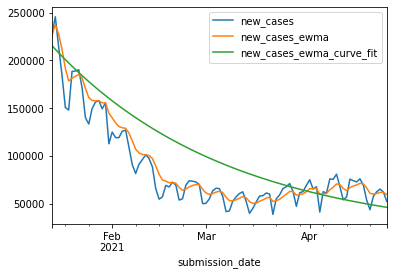

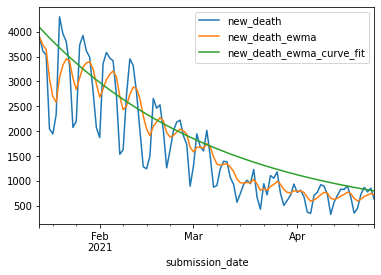

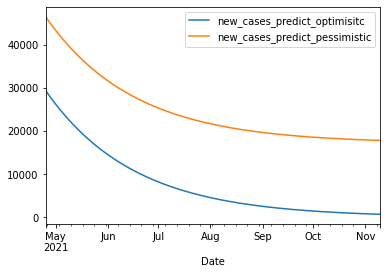

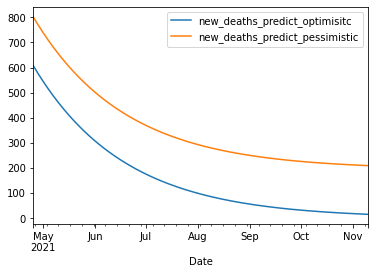

In [241]:
import pandas as pd
import sklearn_pandas as skp
import sklearn as skl
import sklearn.ensemble
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime as dt
from scipy.optimize import curve_fit


##function to build the moving average (N is the size of the sliding window)
def moving_avg(values, N) -> np.array :
  return np.convolve(values, np.ones(N)/N, mode='valid')

##clean the tables
def clean_tables(cases, vac) -> pd.DataFrame :
  #only keep columns "date" and "people_fully_vaccinated" columns for the vaccination table
  vac_clean = vac[["date","people_fully_vaccinated"]]
  #replace 'NaN' by 0
  vac_clean = vac_clean.fillna(0)
  vac_clean.head(20)
  #change date strings to dateTime objects
  vac_clean['date'] = pd.to_datetime(vac_clean['date'])
  vac_clean.index = vac_clean['date']
  vac_clean = vac_clean[['people_fully_vaccinated']]

  #extract "submission_date", "new case", and "new death" columns of the case and death table
  cases_clean = cases[["submission_date","new_case","new_death"]]
  #replace 'NaN' by 0
  cases_clean = cases_clean.fillna(0)
  #sort the date with earlier dates coming first
  cases_clean['submission_date'] = pd.to_datetime(cases_clean['submission_date'])
  cases_clean = cases_clean.sort_values('submission_date')
  #reset the indices and remove the old indices
  cases_clean = cases_clean.reset_index()
  cases_clean = cases_clean[['submission_date','new_case','new_death']]
  #add up daily new cases and new deaths by date
  cases_clean = cases_clean.groupby(['submission_date']).sum()

  #only pick out data between 2021-01-14 and 2021-04-24 because massive vaccination begins at 2021-01-14
  cases_clean = cases_clean['2021-01-14':'2021-04-24']
  vac_clean = vac_clean['2021-01-14':'2021-04-24']

  #merge the tables together
  data_clean = cases_clean.join(vac_clean)

  #append log2 data to the tables because the scale of our data is very different so log
  #can provide uniform visualization
  data_clean['people_fully_vaccinated_log2'] = np.log2(data_clean['people_fully_vaccinated'])
  data_clean['new_case_log2'] = np.log2(data_clean['new_case'])
  data_clean['new_death_log2'] = np.log2(data_clean['new_death'])

  #calculate the moving average for new daily cases and new daily deaths
  #get the moving average of the data with a 7-day sliding window and append them to the tables
  case_numbers = cases_clean['new_case']
  death_numbers = cases_clean['new_death']
  case_numbers_array = case_numbers.to_numpy()
  death_numbers_array = death_numbers.to_numpy()
  case_mavg = moving_avg(case_numbers_array, 7)
  death_mavg = moving_avg(death_numbers, 7)
  case_mavg = np.insert(case_mavg, [0,0,0,0,0,0], values=np.nan)
  death_mavg = np.insert(death_mavg, [0,0,0,0,0,0], values=np.nan)
  data_clean['new_cases_moving_avg'] = case_mavg
  data_clean['new_death_moving_avg'] = death_mavg
  data_clean['new_cases_moving_avg_log2'] = np.log2(case_mavg)
  data_clean['new_death_moving_avg_log2'] = np.log2(death_mavg)

  return data_clean

##function to visualize the table
def visualization(table: pd.DataFrame):
  ax1 = table.plot(y = ['people_fully_vaccinated_log2', 'new_cases_moving_avg_log2', 
                        'new_death_moving_avg_log2', 'new_case_log2', 'new_death_log2'], 
                  style={'new_cases_moving_avg_log2':'black', 'new_case_log2':'r'})
  # ax = table.plot(y = ['people_fully_vaccinated', 'new_cases_moving_avg', 
  #                       'new_death_moving_avg'], logy=True)
  ax1.set(xlabel="Date", ylabel="Total Number log2")
  ax2 = table.plot(y = ['people_fully_vaccinated'])
  ax3 = table.plot(y = ['new_cases_moving_avg'])
  ax4 = table.plot(y = ['new_death_moving_avg'])
  return None

##function to predict future COVID-19 daily cases and deaths
##under the influence of vaccines
def prediction(table: pd.DataFrame, pred_num: int, pred_type: str):

  table_copy = table.copy()
  #convert the date index to categorical values
  table_copy.index = table_copy.index.map(dt.datetime.toordinal)
  #shift the indices to the left by the first index value
  table_copy.index = table_copy.index - table_copy.index[0] + 1
  
  #use ewma model to predict the trend
  #build a 7-day center ewma (com = (7 - 1) / 2)
  new_cases = table['new_case']
  new_death = table['new_death']
  ewma_cases = new_cases.ewm(com = 3).mean()
  ewma_death = new_death.ewm(com = 3).mean()
  y_cases = ewma_cases.to_numpy()
  y_death = ewma_death.to_numpy()
  x = table_copy.index
  #fit the cases data
  #use curve fit to predict based on the exponential moving average
  coef_cases, _ = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y_cases, p0=(225000, 0))
  # y = coef_cases[0] * exp(coef_cases[1] * x)
  # build the regression
  fit = coef_cases[0] * np.exp(np.multiply(coef_cases[1], x))
  #calculate the mean absolute error between the real data and fit
  mae_c = skl.metrics.mean_absolute_error(y_cases, fit)
  #add the error to the fit as the bias
  fit = np.add(mae_c, fit)

  #plot the original data, ewma and regression
  orig_and_fit = pd.DataFrame(index=table.index, data = {'new_cases': new_cases.to_numpy(), 'new_cases_ewma' : y_cases, 'new_cases_ewma_curve_fit': fit})
  orig_and_fit.plot()

  #fit the death data
  #use curve fit to predict based on the exponential moving average
  coef_death, _ = curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y_death, p0=(4000, 0))
  # y = coef_cases[0] * exp(coef_cases[1] * x)
  # build the regression
  fit = coef_death[0] * np.exp(np.multiply(coef_death[1], x))
  #calculate the mean absolute error between the real data and fit
  mae_d = skl.metrics.mean_absolute_error(y_death, fit)
  #add the error to the fit as the bias
  fit = np.add(mae_d, fit)

  #plot the original data, ewma and regression
  orig_and_fit = pd.DataFrame(index=table.index, data = {'new_death': new_death.to_numpy(), 'new_death_ewma' : y_death, 'new_death_ewma_curve_fit': fit})
  orig_and_fit.plot()

  #predict on next 200 days
  x_predict = list(range(len(table_copy.index), len(table_copy.index) + 200))
  y_predict_cases = coef_cases[0] * np.exp(np.multiply(coef_cases[1], x_predict))
  #add the error to the fit as the bias (pessimistic model)
  y_predict_cases_pess = np.add(y_predict_cases, mae_c)
  cases_pred = pd.DataFrame(index=pd.date_range(start="2021-04-25",end="2021-11-10"), 
                                       data={'new_cases_predict_optimisitc': y_predict_cases, 'new_cases_predict_pessimistic': y_predict_cases_pess})
  cases_plot = cases_pred.plot()
  cases_plot.set_xlabel('Date')
  #now predict the death
  y_predict_death = coef_death[0] * np.exp(np.multiply(coef_death[1], x_predict))
  #add the error to the fit as the bias (pessimistic model)
  y_predict_death_pess = np.add(y_predict_death, mae_d)
  death_pred = pd.DataFrame(index=pd.date_range(start="2021-04-25",end="2021-11-10"), 
                                       data={'new_deaths_predict_optimisitc': y_predict_death, 'new_deaths_predict_pessimistic': y_predict_death_pess})
  death_plot = death_pred.plot()
  death_plot.set_xlabel("Date")

  
  #make a prediction based on the predict type the user chooses
  pred = cases_pred.join(death_pred)
  if pred_type is "cases" or pred_type is "deaths":
    print("You want to know the first day that the new {type} will drop below {number}".format(type=pred_type, number=pred_num))
    days_op = pred['new_{type}_predict_optimisitc'.format(type=pred_type)] <= pred_num
    days_pe = pred['new_{type}_predict_pessimistic'.format(type=pred_type)] <= pred_num
    find = False
    for i in range(0, len(days_op)):
      if days_op[i]:
        print("The first day that new {type} will drop below {number} based on the optimistic prediction is {date}".format(
            type=pred_type, number=pred_num, date = pred.index[i]
        ))
        find = True
        break
    for i in range(0, len(days_pe)):
      if days_pe[i]:
        print("The first day that new {type} will drop below {number} based on the pessimistic prediction is {date}".format(
            type=pred_type, number=pred_num, date = pred.index[i]
        ))
        find = True
        break
    if find == False:
      print("Sorry! The new {type} will not drop below {number} in the 200-day prediction range!".format(
          type=pred_type, number=pred_num))
  else:
    print("{type} is not supported in the prediction function.".format(type=pred_type))

  return None

def main():
  #read the datasets TODO: change the path variable for a new session(google colab will remove files stored on cloud after a session ends)
  cases = pd.read_csv("/content/drive/MyDrive/cs6440final/United_States_COVID-19_Cases_and_Deaths_by_State_over_Time.csv")
  vac = pd.read_csv("/content/drive/MyDrive/cs6440final/United States Vaccinations Data.csv")

  #choose the mode TODO: Change the variable to "visualization" or "prediction". 
  mode = 'prediction'

  #first clean the tables and build the table we will use further
  table_clean = clean_tables(cases,vac)

  #Based on the mode, choose operation
  if mode is "visualization":
    visualization(table_clean)
  elif mode is "prediction":
    #TODO: Change the second parameter to any number you want to predict, and change the third to either "cases" or "deaths"
    prediction(table_clean, 20, "deaths")
  else:
    print("Error, {mode} mode is not supported. Please change to either 'visualization' or 'prediction'.".format(mode=mode))

if __name__=="__main__": 
    main()